In [1]:
from skimage.feature import local_binary_pattern
from skimage.feature import hog
from skimage.io import imread
from sklearn.externals import joblib
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import os
import glob
import tqdm

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 6.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
# plt.rcParams['image.cmap'] = 'gray'


%load_ext autoreload
%autoreload 2

In [2]:
def generate_pos_train(file_path, like_img=False):

    # configuration
    orientations = 9
    pixels_per_cell = [5, 5]
    cells_per_block = [3, 3]
    normalize = True

    min_h = 50
    min_w = 50

    for im_path in glob.glob(os.path.join(file_path, '*rgb.png')):
        im = Image.open(im_path)
        im = im.convert('L')
        im = np.asarray(im.resize((min_h, min_w)))
        for i in range(4):
            # generate data from four different rotation
            im = np.rot90(im)
            if not like_img:
                visualize = False
                fd = hog(im, orientations, 
                         pixels_per_cell, cells_per_block, 
                         visualize, normalize)
                hog_img = None
            else:
                visualize = True
                fd, hog_img = hog(im, orientations, 
                                  pixels_per_cell, cells_per_block, 
                                  visualize, normalize)
        
            yield fd, hog_img, im

In [3]:
def plot_img(train_path, pos_or_neg, num_samples=2):   
    if pos_or_neg == 'pos':
        generate_func = generate_pos_train
    elif pos_or_neg == 'neg':
        generate_func = generate_neg_train
    
    count = 0
    for _, hog_img, img in generate_func(train_path, True):
        count += 1     
        plt_idx = count
        plt.subplot(num_samples, 5, plt_idx)
        plt.imshow(hog_img)
        plt.axis('off')
        
        if count%5 == 4:
            count += 1
            plt.subplot(num_samples, 5, count)
            plt.imshow(img)
            plt.axis('off')
            
        if count == 5 * num_samples:
            break
        
    plt.show()

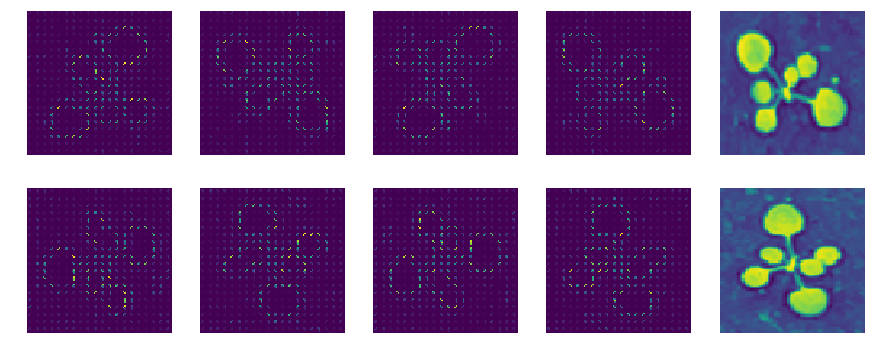

In [4]:
current_path = os.getcwd()
pos_train_path = os.path.join(current_path, 'Datasets', 'Plant', 'Ara2013-RPi')
plot_img(pos_train_path, 'pos')

In [3]:
def generate_neg_train(file_path, like_img=False):

    # configuration
    orientations = 9
    pixels_per_cell = [5, 5]
    cells_per_block = [3, 3]
    visualize = False
    normalize = True
    
    min_h = 50
    min_w = 50

    for im_path in glob.glob(os.path.join(file_path, '*')):
        im = Image.open(im_path)
        im = im.convert('L')
        w_im, h_im = im.size[0], im.size[1]
        im = np.asarray(im)
        for h in range(h_im // min_h):
            for w in range(w_im // min_w):
                crop_im = im[min_h*h:min_h*(h+1), min_w*w:min_w*(w+1)]
                for i in range(4):
                    crop_im = np.rot90(crop_im)
                    if not like_img:
                        visualize = False
                        fd = hog(crop_im, orientations, 
                                 pixels_per_cell, cells_per_block, 
                                 visualize, normalize)
                        hog_img = None

                    else:
                        visualize = True
                        fd, hog_img = hog(crop_im, orientations, 
                                          pixels_per_cell, cells_per_block, 
                                          visualize, normalize)


                    # generate data from four different rotation
                    yield fd, hog_img, crop_im


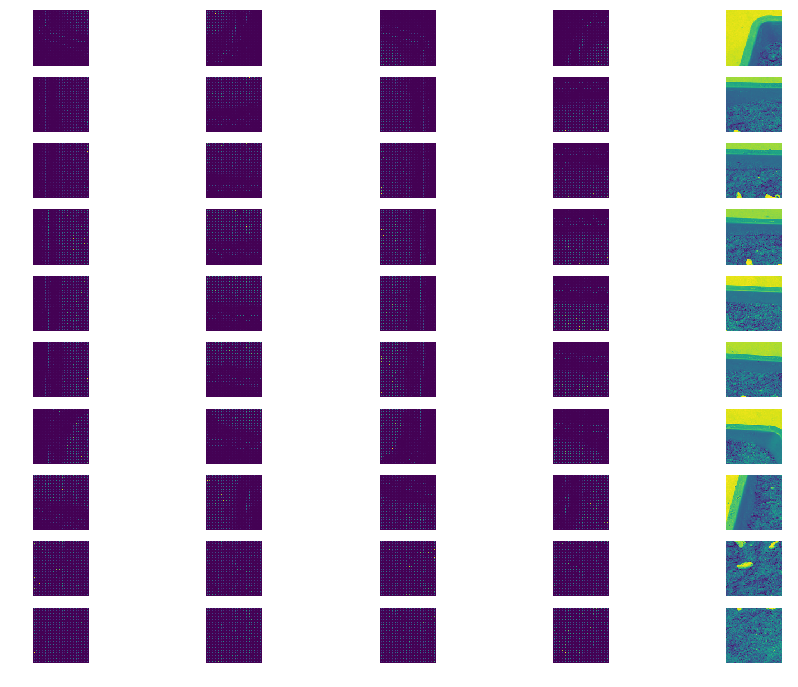

In [38]:
current_path = os.getcwd()
neg_train_path = os.path.join(current_path, 'Datasets', 'Negative')
plot_img(neg_train_path, 'neg')

# SVM classifier

In [4]:
current_path = os.getcwd()
pos_train_path_1 = os.path.join(current_path, 'Datasets', 'Plant', 'Ara2013-RPi')
pos_train_path_2 = os.path.join(current_path, 'Datasets', 'Plant', 'Ara2013-Canon')
pos_train_path_3 = os.path.join(current_path, 'Datasets', 'Plant', 'Ara2012')

In [5]:
neg_train_path = os.path.join(current_path, 'Datasets', 'Negative')

In [6]:
fds = []
labels = []

for pos_example, _, _ in generate_pos_train(pos_train_path_1):
    fds.append(pos_example)
    labels.append(1)
    
for pos_example, _, _ in generate_pos_train(pos_train_path_2):
    fds.append(pos_example)
    labels.append(1)
    
for pos_example, _, _ in generate_pos_train(pos_train_path_3):
    fds.append(pos_example)
    labels.append(1)

In [7]:
for neg_example, _, _ in generate_neg_train(neg_train_path):
    fds.append(neg_example)
    labels.append(0)

In [9]:
len(fds)

7480

In [8]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    fds, labels, test_size=0.2, random_state=0)

clf = LinearSVC()
clf.fit(X_train, y_train)
print('train accuracy: ', clf.score(X_train, y_train))
print('test accuracy: ', clf.score(X_test, y_test))

train accuracy:  0.999832887701
test accuracy:  0.98128342246


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from '/Users/sunjiajun/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py'>

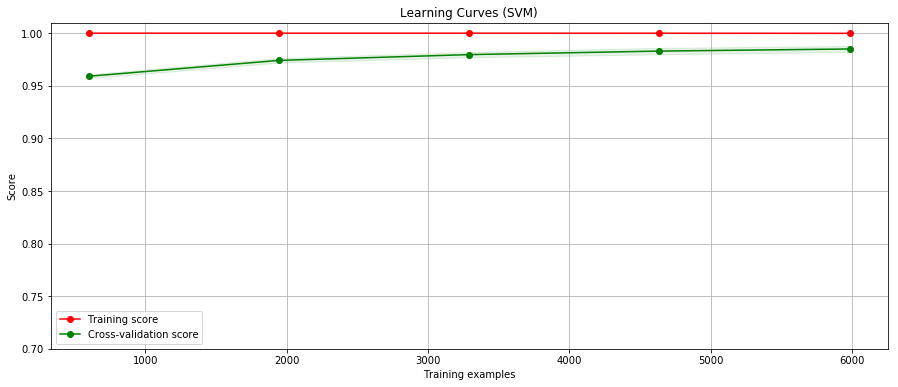

In [21]:
from sklearn.svm import LinearSVC
X, y = fds, labels


title = "Learning Curves (SVM)"
# Cross validation with 20 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=4, test_size=0.2, random_state=0)
estimator = LinearSVC()
plot_learning_curve(estimator, title, X, y, ylim=(0.7, 1.01), cv=cv, n_jobs=1)

# Object Detection

In [11]:
def sliding_window(image, window_size, step_size):
    '''
    This function returns a patch of the input image `image` of size equal
    to `window_size`. The first image returned top-left co-ordinates (0, 0) 
    and are increment in both x and y directions by the `step_size` supplied.
    So, the input parameters are -
    * `image` - Input Image
    * `window_size` - Size of Sliding Window
    * `step_size` - Incremented Size of Window
    The function returns a tuple -
    (x, y, im_window)
    where
    * x is the top-left x co-ordinate
    * y is the top-left y co-ordinate
    * im_window is the sliding window image
    '''
    for y in range(0, image.shape[0], step_size[1]):
        for x in range(0, image.shape[1], step_size[0]):
            yield (x, y, image[y:y + window_size[1], x:x + window_size[0]])

In [12]:
def nms(detections, threshold=.5):
    '''
    This function performs Non-Maxima Suppression.
    `detections` consists of a list of detections.
    Each detection is in the format ->
    [x-top-left, y-top-left, confidence-of-detections, width-of-detection, height-of-detection]
    If the area of overlap is greater than the `threshold`,
    the area with the lower confidence score is removed.
    The output is a list of detections.
    '''
    if len(detections) == 0:
        return []
    # Sort the detections based on confidence score
    detections = sorted(detections, key=lambda detections: detections[2],
            reverse=True)
    # Unique detections will be appended to this list
    new_detections=[]
    # Append the first detection
    new_detections.append(detections[0])
    # Remove the detection from the original list
    del detections[0]
    # For each detection, calculate the overlapping area
    # and if area of overlap is less than the threshold set
    # for the detections in `new_detections`, append the 
    # detection to `new_detections`.
    # In either case, remove the detection from `detections` list.
    for index, detection in enumerate(detections):
        for new_detection in new_detections:
            if overlapping_area(detection, new_detection) > threshold:
                del detections[index]
                break
        else:
            new_detections.append(detection)
            del detections[index]
    return new_detections

In [13]:
def overlapping_area(detection_1, detection_2):
    '''
    Function to calculate overlapping area'si
    `detection_1` and `detection_2` are 2 detections whose area
    of overlap needs to be found out.
    Each detection is list in the format ->
    [x-top-left, y-top-left, confidence-of-detections, width-of-detection, height-of-detection]
    The function returns a value between 0 and 1,
    which represents the area of overlap.
    0 is no overlap and 1 is complete overlap.
    Area calculated from ->
    http://math.stackexchange.com/questions/99565/simplest-way-to-calculate-the-intersect-area-of-two-rectangles
    '''
    # Calculate the x-y co-ordinates of the 
    # rectangles
    x1_tl = detection_1[0]
    x2_tl = detection_2[0]
    x1_br = detection_1[0] + detection_1[3]
    x2_br = detection_2[0] + detection_2[3]
    y1_tl = detection_1[1]
    y2_tl = detection_2[1]
    y1_br = detection_1[1] + detection_1[4]
    y2_br = detection_2[1] + detection_2[4]
    # Calculate the overlapping Area
    x_overlap = max(0, min(x1_br, x2_br)-max(x1_tl, x2_tl))
    y_overlap = max(0, min(y1_br, y2_br)-max(y1_tl, y2_tl))
    overlap_area = x_overlap * y_overlap
    area_1 = detection_1[3] * detection_2[4]
    area_2 = detection_2[3] * detection_2[4]
    total_area = area_1 + area_2 - overlap_area
    return overlap_area / float(total_area)

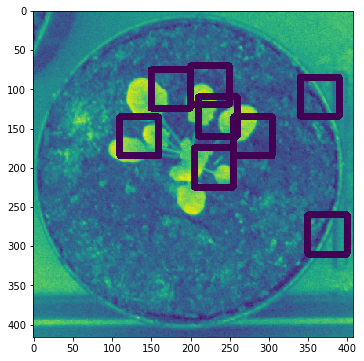

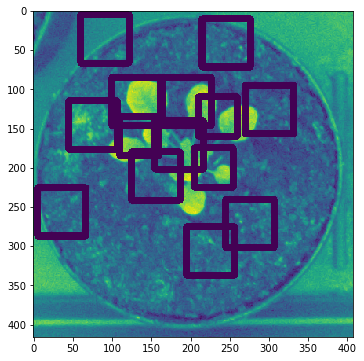

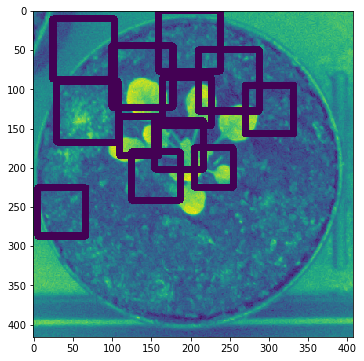

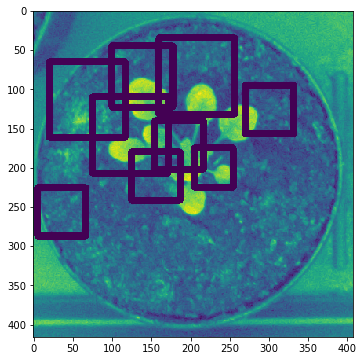

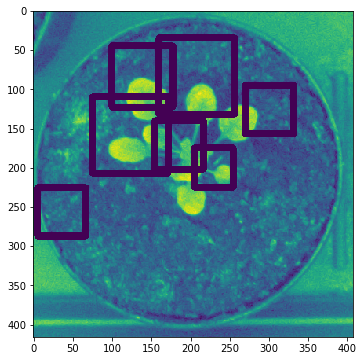

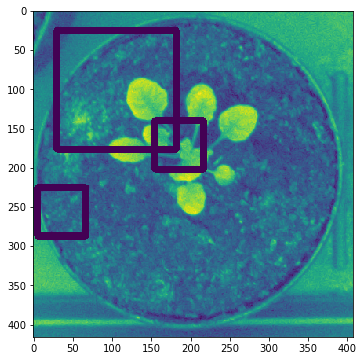

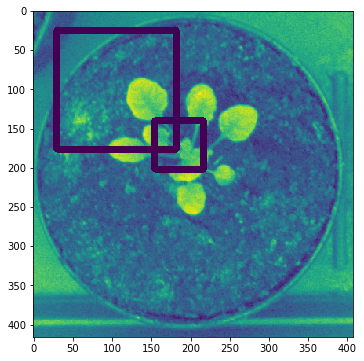

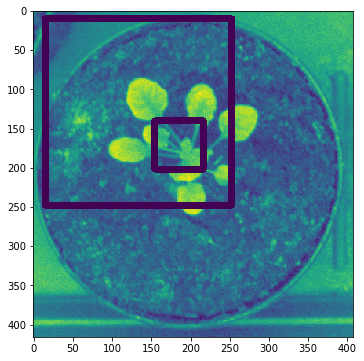

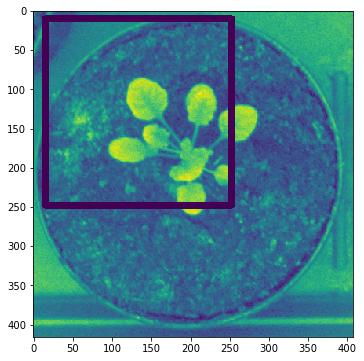

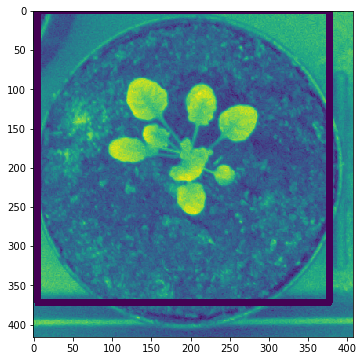

In [18]:
from skimage.transform import pyramid_gaussian
import cv2

min_window_size = (50, 50)
step_size = (5, 5)
downscale = 1.25
visualize_det = False
threshold = 0.15

detections = []
scale = 0

orientations = 9
pixels_per_cell = [5, 5]
cells_per_block = [3, 3]
visualize = False
normalize = True

img_path = os.path.join(current_path, 'Datasets', 'Stacks', 'Ara2012', 'stack_02','ara2012_plant02_frame03_rgb.png')
im = imread(img_path, as_grey=True)

for im_scaled in pyramid_gaussian(im, downscale=downscale):
    cd = []
    if im_scaled.shape[0] < min_window_size[0] or im_scaled.shape[1] < min_window_size[1]:
        break
    for (x, y, im_window) in sliding_window(im_scaled, min_window_size, step_size):
            if im_window.shape[0] != min_window_size[1] or im_window.shape[1] != min_window_size[0]:
                continue
            # Calculate the HOG features
            fd = hog(im_window, orientations, pixels_per_cell, cells_per_block, visualize, normalize)
            fd = fd.reshape((1, -1))
            pred = clf.predict(fd)
            if pred == 1:
#                 print("Detection:: Location -> ({}, {})".format(x, y))
#                 print("Scale ->  {} | Confidence Score {} \n".format(scale,clf.decision_function(fd)))
                detections.append((x, y, clf.decision_function(fd),
                    int(min_window_size[0]*(downscale**scale)),
                    int(min_window_size[1]*(downscale**scale))))
                cd.append(detections[-1])

    # Move the the next scale
    scale+=1

    # Display the results before performing NMS
    clone = im.copy()

    # Perform Non Maxima Suppression
    detections = nms(detections, threshold)

    # Display the results after performing NMS
    for (x_tl, y_tl, _, w, h) in detections:
        # Draw the detections
        cv2.rectangle(clone, (x_tl, y_tl), (x_tl+w,y_tl+h), (0, 0, 0), thickness=8)
    
    plt.imshow(clone)
    plt.show()